## __기본옵션__

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os, glob
import numpy as np
import pandas as pd
from PIL import Image
import pickle
import cv2
import matplotlib.pyplot as plt
import warnings 
from time import time
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Input, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization,Add,Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.layers import LeakyReLU, ReLU, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, UpSampling2D, concatenate
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.models import Sequential

Using TensorFlow backend.


In [ ]:
dir = "/content/drive/My Drive/KPMG/classifier"
os.chdir(dir)

In [ ]:
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1b_hRSn7Iv5YQuHEzPFQ4BDR-3HIbmmjI/KPMG/classifier'

## __데이터 불러오기__

In [ ]:
# pickle파일 read
with open("/content/drive/My Drive/KPMG/classifier/pickle/batang.pkl","rb") as pk:
  batang_pk = pickle.load(pk)
with open("/content/drive/My Drive/KPMG/classifier/pickle/dotum.pkl","rb") as pk:
  dotum_pk = pickle.load(pk)
with open("/content/drive/My Drive/KPMG/classifier/pickle/gothic.pkl","rb") as pk:
  gothic_pk = pickle.load(pk)
with open("/content/drive/My Drive/KPMG/classifier/pickle/myeongjo.pkl","rb") as pk:
  myeongjo_pk = pickle.load(pk)


In [ ]:
# 전체 이미지 array 저장해놓은 것
# image_all = batang_pk+dotum_pk+gothic_pk+myeongjo_pk
batang_pk=np.array(batang_pk)
dotum_pk=np.array(dotum_pk)
gothic_pk=np.array(gothic_pk)
myeongjo_pk=np.array(myeongjo_pk)

In [ ]:
# seed설정
np.random.seed(0)

# 인덱스 만들어 주고 순서를 랜덤으로 바꾸어 인덱스를 출력해주는 함수
def make_index_permutation(font_pk):
  result=np.random.permutation(np.arange(len(font_pk)))
  return result


In [ ]:
batang_index=make_index_permutation(batang_pk)
dotum_index=make_index_permutation(dotum_pk)
gothic_index=make_index_permutation(gothic_pk)
myeongjo_index=make_index_permutation(myeongjo_pk)

In [ ]:
import math

## font_index를 slicing으로 split 해주고 리스트에 추가해주는 함수

def data_split_merge(split_cnt,font_index):
  result=[]
  for i in range(0,split_cnt):
    result.append(font_index[round((i*(len(font_index))/split_cnt)):round((i+1)*(len(font_index))/split_cnt)])
  return result


In [ ]:
split_cnt = 8

batang_index_list=data_split_merge(split_cnt,batang_index)
dotum_index_list=data_split_merge(split_cnt,dotum_index)
gothic_index_list=data_split_merge(split_cnt,gothic_index)
myeongjo_index_list=data_split_merge(split_cnt,myeongjo_index)


In [ ]:
# 원하는 갯수로 train data로 나눠주는 함수

def make_train_data(split_cnt,font_pk,font_index_list):
  result=[]
  for i in range(split_cnt):
    result.append(font_pk[font_index_list[i]])
  return result

In [ ]:
batang_train=make_train_data(split_cnt,batang_pk,batang_index_list)
dotum_train=make_train_data(split_cnt,dotum_pk,dotum_index_list)
gothic_train=make_train_data(split_cnt,gothic_pk,gothic_index_list)
myeongjo_train=make_train_data(split_cnt,myeongjo_pk,myeongjo_index_list)

total_train=[]
for i in range(split_cnt):
  total_train.append(batang_train[i].tolist()+dotum_train[i].tolist()+gothic_train[i].tolist()+myeongjo_train[i].tolist())

In [ ]:
total_df_list=[]

for i in range(split_cnt):
  batang_df= pd.DataFrame({'image':batang_train[i], 'category':0})
  dotum_df = pd.DataFrame({'image':dotum_train[i], 'category':1})
  gothic_df = pd.DataFrame({'image':gothic_train[i], 'category':2})
  myeongjo_df = pd.DataFrame({'image':myeongjo_train[i], 'category':3})
  total_df=pd.concat([batang_df,dotum_df,gothic_df,myeongjo_df])
  total_df.reset_index(drop=True, inplace=True)
  total_df_list.append(total_df)

In [ ]:
X_list=[]

def make_X_list(total_train_data):
  img=[]
  for i in range(len(total_train_data)):
    img.append(cv2.resize(total_train_data[i],(71,71)))
  return img


In [ ]:
for i in range(split_cnt):
  X_list.append(make_X_list(total_train[i]))

## __모델링 (Xception)__

### Train, Validation Split

In [ ]:
def make_train_XY(X,total_df_list,idx):
  return X_list[idx],np.array(total_df_list[idx]['category'])

#### 아래 train_XY안에 있는 idx를 0~split_cnt-1까지 바꿔주면서 넣어주기만 하면 됨

X,Y=make_train_XY(X_list,total_df_list,0)
X=np.array(X)

In [ ]:
X.shape

(13806, 71, 71, 3)

In [ ]:
Y.shape

(13806,)

In [ ]:
# Train, valid set split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, 
                                                    stratify=Y ,random_state=1234)

In [ ]:
def Time(model, train_X,train_Y, batch_size, n_epoch):

  training_start_time = time()
  trained_model = model.fit(train_X, train_Y,
                            batch_size=batch_size, epochs=n_epoch,
                            validation_split = 0.2)
  training_end_time = time()
  print("Training time finished.\n%d epochs in %12.2f" % (n_epoch,
                                                          training_end_time - training_start_time))
  return trained_model

### Xception 모델

In [ ]:
# Xception shape는 최소 71x71
from keras.applications.xception import Xception, decode_predictions
xcep = Xception(weights='imagenet', include_top=False, input_shape=(71,71,3), classes=4)
xcep.trainable=True
# xcep.summary()

from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(xcep)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

83689472/83683744 [==============================] - 7s 0us/step


#### optimizer 확인

##### adam

In [ ]:
# Xception shape는 최소 71x71
# from keras.applications.xception import Xception, decode_predictions
xcep = Xception(weights='imagenet', include_top=False, input_shape=(71,71,3), classes=4)
xcep.trainable=True
# xcep.summary()

from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(xcep)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
fitted_model=Time(model,X_train,y_train,batch_size=500,n_epoch=20)

score = model.evaluate(X_test, y_test)
print(score)
print("loss : ", score[0])
print("accuracy : ", score[1])

Train on 8835 samples, validate on 2209 samples
Epoch 1/20
8835/8835 [==============================] - 62s 7ms/step - loss: 1.4416 - accuracy: 0.3048 - val_loss: 1.6142 - val_accuracy: 0.3096
Epoch 2/20
8835/8835 [==============================] - 32s 4ms/step - loss: 1.3616 - accuracy: 0.3195 - val_loss: 1.4097 - val_accuracy: 0.2182
Epoch 3/20
8835/8835 [==============================] - 33s 4ms/step - loss: 1.3661 - accuracy: 0.3265 - val_loss: 1.3676 - val_accuracy: 0.3219
Epoch 4/20
8835/8835 [==============================] - 32s 4ms/step - loss: 1.3318 - accuracy: 0.3536 - val_loss: 1.3220 - val_accuracy: 0.3658
Epoch 5/20
8835/8835 [==============================] - 32s 4ms/step - loss: 1.0881 - accuracy: 0.4844 - val_loss: 1.3521 - val_accuracy: 0.3993
Epoch 6/20
8835/8835 [==============================] - 32s 4ms/step - loss: 0.7189 - accuracy: 0.6054 - val_loss: 1.0666 - val_accuracy: 0.5084
Epoch 7/20
8835/8835 [==============================] - 32s 4ms/step - loss: 0.621

##### nadam

In [ ]:
# Xception shape는 최소 71x71
# from keras.applications.xception import Xception, decode_predictions
xcep = Xception(weights='imagenet', include_top=False, input_shape=(71,71,3), classes=4)
xcep.trainable=True
# xcep.summary()

from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(xcep)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
fitted_model=Time(model,X_train,y_train,batch_size=500,n_epoch=20)

score = model.evaluate(X_test, y_test)
print(score)
print("loss : ", score[0])
print("accuracy : ", score[1])

Train on 8835 samples, validate on 2209 samples
Epoch 1/20
8835/8835 [==============================] - 45s 5ms/step - loss: 1.4624 - accuracy: 0.3083 - val_loss: 1.9138 - val_accuracy: 0.3214
Epoch 2/20
8835/8835 [==============================] - 33s 4ms/step - loss: 1.3491 - accuracy: 0.3185 - val_loss: 1.4242 - val_accuracy: 0.3214
Epoch 3/20
8835/8835 [==============================] - 32s 4ms/step - loss: 1.3489 - accuracy: 0.3185 - val_loss: 1.3760 - val_accuracy: 0.3214
Epoch 4/20
8835/8835 [==============================] - 33s 4ms/step - loss: 1.3491 - accuracy: 0.3185 - val_loss: 1.3507 - val_accuracy: 0.3214
Epoch 5/20
8835/8835 [==============================] - 33s 4ms/step - loss: 1.3489 - accuracy: 0.3185 - val_loss: 1.3489 - val_accuracy: 0.3214
Epoch 6/20
8835/8835 [==============================] - 33s 4ms/step - loss: 1.3488 - accuracy: 0.3185 - val_loss: 1.3483 - val_accuracy: 0.3214
Epoch 7/20
8835/8835 [==============================] - 33s 4ms/step - loss: 1.348

##### SGD

In [ ]:
# Xception shape는 최소 71x71
# from keras.applications.xception import Xception, decode_predictions
xcep = Xception(weights='imagenet', include_top=False, input_shape=(71,71,3), classes=4)
xcep.trainable=True
# xcep.summary()

from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(xcep)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
fitted_model=Time(model,X_train,y_train,batch_size=500,n_epoch=20)

score = model.evaluate(X_test, y_test)
print(score)
print("loss : ", score[0])
print("accuracy : ", score[1])

Train on 8835 samples, validate on 2209 samples
Epoch 1/20
8835/8835 [==============================] - 40s 5ms/step - loss: 1.2772 - accuracy: 0.3213 - val_loss: 2.9141 - val_accuracy: 0.3214
Epoch 2/20
8835/8835 [==============================] - 33s 4ms/step - loss: 1.1234 - accuracy: 0.4263 - val_loss: 2.3679 - val_accuracy: 0.3228
Epoch 3/20
8835/8835 [==============================] - 32s 4ms/step - loss: 1.0409 - accuracy: 0.5205 - val_loss: 1.7820 - val_accuracy: 0.2974
Epoch 4/20
8835/8835 [==============================] - 33s 4ms/step - loss: 0.9955 - accuracy: 0.5554 - val_loss: 1.7168 - val_accuracy: 0.3201
Epoch 5/20
8835/8835 [==============================] - 33s 4ms/step - loss: 0.9376 - accuracy: 0.5991 - val_loss: 1.5906 - val_accuracy: 0.3228
Epoch 6/20
8835/8835 [==============================] - 33s 4ms/step - loss: 0.8925 - accuracy: 0.6275 - val_loss: 1.1833 - val_accuracy: 0.4201
Epoch 7/20
8835/8835 [==============================] - 33s 4ms/step - loss: 0.799

##### Adadelta

In [ ]:
# Xception shape는 최소 71x71
# from keras.applications.xception import Xception, decode_predictions
xcep = Xception(weights='imagenet', include_top=False, input_shape=(71,71,3), classes=4)
xcep.trainable=True
# xcep.summary()

from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(xcep)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adadelta", metrics=["accuracy"])
fitted_model=Time(model,X_train,y_train,batch_size=500,n_epoch=20)

score = model.evaluate(X_test, y_test)
print(score)
print("loss : ", score[0])
print("accuracy : ", score[1])

Train on 8835 samples, validate on 2209 samples
Epoch 1/20
8835/8835 [==============================] - 43s 5ms/step - loss: 1.5677 - accuracy: 0.4003 - val_loss: 13.9247 - val_accuracy: 0.3214
Epoch 2/20
8835/8835 [==============================] - 33s 4ms/step - loss: 0.8335 - accuracy: 0.6247 - val_loss: 5.6800 - val_accuracy: 0.3228
Epoch 3/20
8835/8835 [==============================] - 33s 4ms/step - loss: 0.4539 - accuracy: 0.7457 - val_loss: 3.3872 - val_accuracy: 0.3957
Epoch 4/20
8835/8835 [==============================] - 33s 4ms/step - loss: 0.2080 - accuracy: 0.9067 - val_loss: 2.0193 - val_accuracy: 0.5156
Epoch 5/20
8835/8835 [==============================] - 33s 4ms/step - loss: 0.0653 - accuracy: 0.9802 - val_loss: 2.4793 - val_accuracy: 0.5632
Epoch 6/20
8835/8835 [==============================] - 33s 4ms/step - loss: 0.0146 - accuracy: 0.9958 - val_loss: 2.5636 - val_accuracy: 0.6197
Epoch 7/20
8835/8835 [==============================] - 33s 4ms/step - loss: 0.01

##### Rmsprop

In [ ]:
# Xception shape는 최소 71x71
# from keras.applications.xception import Xception, decode_predictions
xcep = Xception(weights='imagenet', include_top=False, input_shape=(71,71,3), classes=4)
xcep.trainable=True
# xcep.summary()

from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(xcep)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
fitted_model=Time(model,X_train,y_train,batch_size=500,n_epoch=20)

score = model.evaluate(X_test, y_test)
print(score)
print("loss : ", score[0])
print("accuracy : ", score[1])

Train on 8835 samples, validate on 2209 samples
Epoch 1/20
8835/8835 [==============================] - 40s 4ms/step - loss: 2.6484 - accuracy: 0.3066 - val_loss: 1.4065 - val_accuracy: 0.2594
Epoch 2/20
8835/8835 [==============================] - 31s 4ms/step - loss: 1.3749 - accuracy: 0.3184 - val_loss: 1.3713 - val_accuracy: 0.3015
Epoch 3/20
8835/8835 [==============================] - 32s 4ms/step - loss: 1.3527 - accuracy: 0.3182 - val_loss: 1.3492 - val_accuracy: 0.3214
Epoch 4/20
8835/8835 [==============================] - 33s 4ms/step - loss: 1.3207 - accuracy: 0.3185 - val_loss: 1.3045 - val_accuracy: 0.3214
Epoch 5/20
8835/8835 [==============================] - 32s 4ms/step - loss: 1.3014 - accuracy: 0.3185 - val_loss: 1.2649 - val_accuracy: 0.3214
Epoch 6/20
8835/8835 [==============================] - 32s 4ms/step - loss: 1.2400 - accuracy: 0.3454 - val_loss: 5.3530 - val_accuracy: 0.4839
Epoch 7/20
8835/8835 [==============================] - 32s 4ms/step - loss: 1.179

##### adagrad

In [ ]:
# Xception shape는 최소 71x71
# from keras.applications.xception import Xception, decode_predictions
xcep = Xception(weights='imagenet', include_top=False, input_shape=(71,71,3), classes=4)
xcep.trainable=True
# xcep.summary()

from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(xcep)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adagrad", metrics=["accuracy"])
fitted_model=Time(model,X_train,y_train,batch_size=500,n_epoch=20)

score = model.evaluate(X_test, y_test)
print(score)
print("loss : ", score[0])
print("accuracy : ", score[1])

Train on 8835 samples, validate on 2209 samples
Epoch 1/20
8835/8835 [==============================] - 41s 5ms/step - loss: 10.7062 - accuracy: 0.3025 - val_loss: 8101.1503 - val_accuracy: 0.3214
Epoch 2/20
8835/8835 [==============================] - 32s 4ms/step - loss: 1.3084 - accuracy: 0.3149 - val_loss: 322.2421 - val_accuracy: 0.3214
Epoch 3/20
8835/8835 [==============================] - 32s 4ms/step - loss: 1.0936 - accuracy: 0.4656 - val_loss: 55.6744 - val_accuracy: 0.3214
Epoch 4/20
8835/8835 [==============================] - 33s 4ms/step - loss: 0.8193 - accuracy: 0.5218 - val_loss: 114.0925 - val_accuracy: 0.2707
Epoch 5/20
8835/8835 [==============================] - 33s 4ms/step - loss: 0.7027 - accuracy: 0.5899 - val_loss: 20.8829 - val_accuracy: 0.3214
Epoch 6/20
8835/8835 [==============================] - 32s 4ms/step - loss: 0.5952 - accuracy: 0.6655 - val_loss: 6.6461 - val_accuracy: 0.3481
Epoch 7/20
8835/8835 [==============================] - 33s 4ms/step - l

모델저장 에러   
https://mylifemystudy.tistory.com/69

#### Training
- optimizer : Adadelta  
- epoch : 20  
- batch size : 500

##### 1번째 학습

In [ ]:
#### 아래 train_XY안에 있는 idx를 0~split_cnt-1까지 바꿔주면서 넣어주기만 하면 됨
X,Y=make_train_XY(X_list,total_df_list,0)
X=np.array(X)

# Train, valid set split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, 
                                                    stratify=Y ,random_state=1234)

# Xception shape는 최소 71x71
from keras.applications.xception import Xception, decode_predictions
xcep = Xception(weights='imagenet', include_top=False, input_shape=(71,71,3), classes=4)
xcep.trainable=True
# xcep.summary()

from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(xcep)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

In [ ]:
import tensorflow as tf
run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adadelta", metrics=["accuracy"])

def Time(model, train_X,train_Y, batch_size, n_epoch):

  training_start_time = time()
  trained_model = model.fit(train_X, train_Y,
                            batch_size=batch_size, epochs=n_epoch,
                            validation_split = 0.2)
  training_end_time = time()
  print("Training time finished.\n%d epochs in %12.2f" % (n_epoch,
                                                          training_end_time - training_start_time))
  return trained_model

fitted_model=Time(model,X_train,y_train,batch_size=500,n_epoch=20)

Train on 8835 samples, validate on 2209 samples
Epoch 1/20


ResourceExhaustedError: ignored

In [ ]:
# 모델저장
from keras.models import model_from_json
model_json = model.to_json()
with open("/content/drive/My Drive/KPMG/classifier/model/xcep_model_1.json", "w") as json_file:
  json_file.write(model_json)

# 가중치 저장
model.save_weights("/content/drive/My Drive/KPMG/classifier/model/xcep_weight_1.h5")

##### 2번째 학습

In [ ]:
from tensorflow.compat.v2.keras.models import model_from_json

# 모델, weight 로드
json_file = open("/content/drive/My Drive/KPMG/classifier/model/xcep_model_1.json", "r")
loaded_model_json = json_file.read()
json_file.close()

# json파일로부터 model load
loaded_model = model_from_json(loaded_model_json)

# model에 weight 로드하기
weight = '/content/drive/My Drive/KPMG/classifier/model/xcep_weight_1.h5'
loaded_model.load_weights(weight)

In [ ]:
#### 아래 train_XY안에 있는 idx를 0~split_cnt-1까지 바꿔주면서 넣어주기만 하면 됨
X,Y=make_train_XY(X_list,total_df_list,1)
X=np.array(X)

# Train, valid set split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, 
                                                    stratify=Y ,random_state=1234)

# 학습
loaded_model.compile(loss="sparse_categorical_crossentropy", optimizer="adadelta", metrics=["accuracy"])
fitted_model=Time(loaded_model,X_train,y_train,batch_size=500,n_epoch=20)

In [ ]:
# 모델저장
from keras.models import model_from_json
loaded_model_json = loaded_model.to_json()
with open("/content/drive/My Drive/KPMG/classifier/model/xcep_model_2.json", "w") as json_file:
  json_file.write(loaded_model_json)

# 가중치 저장
loaded_model.save_weights("/content/drive/My Drive/KPMG/classifier/model/xcep_weight_2.h5")

##### 3번째 학습

In [ ]:
from tensorflow.compat.v2.keras.models import model_from_json

# 모델, weight 로드
json_file = open("/content/drive/My Drive/KPMG/classifier/model/xcep_model_2.json", "r")
loaded_model_json = json_file.read()
json_file.close()

# json파일로부터 model load
loaded_model = model_from_json(loaded_model_json)

# model에 weight 로드하기
weight = '/content/drive/My Drive/KPMG/classifier/model/xcep_weight_2.h5'
loaded_model.load_weights(weight)

In [ ]:
#### 아래 train_XY안에 있는 idx를 0~split_cnt-1까지 바꿔주면서 넣어주기만 하면 됨
X,Y=make_train_XY(X_list,total_df_list,2)
X=np.array(X)

# Train, valid set split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, 
                                                    stratify=Y ,random_state=1234)

# 학습
loaded_model.compile(loss="sparse_categorical_crossentropy", optimizer="adadelta", metrics=["accuracy"])
fitted_model=Time(loaded_model,X_train,y_train,batch_size=500,n_epoch=20)

In [ ]:
# 모델저장
from keras.models import model_from_json
loaded_model_json = loaded_model.to_json()
with open("/content/drive/My Drive/KPMG/classifier/model/xcep_model_3.json", "w") as json_file:
  json_file.write(loaded_model_json)

# 가중치 저장
loaded_model.save_weights("/content/drive/My Drive/KPMG/classifier/model/xcep_weight_3.h5")

##### 4번째 학습

In [ ]:
from tensorflow.compat.v2.keras.models import model_from_json

# 모델, weight 로드
json_file = open("/content/drive/My Drive/KPMG/classifier/model/xcep_model_3.json", "r")
loaded_model_json = json_file.read()
json_file.close()

# json파일로부터 model load
loaded_model = model_from_json(loaded_model_json)

# model에 weight 로드하기
weight = '/content/drive/My Drive/KPMG/classifier/model/xcep_weight_3.h5'
loaded_model.load_weights(weight)

In [ ]:
#### 아래 train_XY안에 있는 idx를 0~split_cnt-1까지 바꿔주면서 넣어주기만 하면 됨
X,Y=make_train_XY(X_list,total_df_list,3)
X=np.array(X)

# Train, valid set split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, 
                                                    stratify=Y ,random_state=1234)

# 학습
loaded_model.compile(loss="sparse_categorical_crossentropy", optimizer="adadelta", metrics=["accuracy"])
fitted_model=Time(loaded_model,X_train,y_train,batch_size=500,n_epoch=20)

In [ ]:
# 모델저장
from keras.models import model_from_json
loaded_model_json = loaded_model.to_json()
with open("/content/drive/My Drive/KPMG/classifier/model/xcep_model_4.json", "w") as json_file:
  json_file.write(loaded_model_json)

# 가중치 저장
loaded_model.save_weights("/content/drive/My Drive/KPMG/classifier/model/xcep_weight_4.h5")

##### 5번째 학습

In [ ]:
from tensorflow.compat.v2.keras.models import model_from_json

# 모델, weight 로드
json_file = open("/content/drive/My Drive/KPMG/classifier/model/xcep_model_4.json", "r")
loaded_model_json = json_file.read()
json_file.close()

# json파일로부터 model load
loaded_model = model_from_json(loaded_model_json)

# model에 weight 로드하기
weight = '/content/drive/My Drive/KPMG/classifier/model/xcep_weight_4.h5'
loaded_model.load_weights(weight)

In [ ]:
#### 아래 train_XY안에 있는 idx를 0~split_cnt-1까지 바꿔주면서 넣어주기만 하면 됨
X,Y=make_train_XY(X_list,total_df_list,4)
X=np.array(X)

# Train, valid set split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, 
                                                    stratify=Y ,random_state=1234)

# 학습
loaded_model.compile(loss="sparse_categorical_crossentropy", optimizer="adadelta", metrics=["accuracy"])
fitted_model=Time(loaded_model,X_train,y_train,batch_size=500,n_epoch=20)

In [ ]:
# 모델저장
from keras.models import model_from_json
loaded_model_json = loaded_model.to_json()
with open("/content/drive/My Drive/KPMG/classifier/model/xcep_model_5.json", "w") as json_file:
  json_file.write(loaded_model_json)

# 가중치 저장
loaded_model.save_weights("/content/drive/My Drive/KPMG/classifier/model/xcep_weight_5.h5")

##### 6번째 학습

In [ ]:
from tensorflow.compat.v2.keras.models import model_from_json

# 모델, weight 로드
json_file = open("/content/drive/My Drive/KPMG/classifier/model/xcep_model_5.json", "r")
loaded_model_json = json_file.read()
json_file.close()

# json파일로부터 model load
loaded_model = model_from_json(loaded_model_json)

# model에 weight 로드하기
weight = '/content/drive/My Drive/KPMG/classifier/model/xcep_weight_5.h5'
loaded_model.load_weights(weight)

In [ ]:
#### 아래 train_XY안에 있는 idx를 0~split_cnt-1까지 바꿔주면서 넣어주기만 하면 됨
X,Y=make_train_XY(X_list,total_df_list,5)
X=np.array(X)

# Train, valid set split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, 
                                                    stratify=Y ,random_state=1234)

# 학습
loaded_model.compile(loss="sparse_categorical_crossentropy", optimizer="adadelta", metrics=["accuracy"])
fitted_model=Time(loaded_model,X_train,y_train,batch_size=500,n_epoch=20)

In [ ]:
# 모델저장
from keras.models import model_from_json
loaded_model_json = loaded_model.to_json()
with open("/content/drive/My Drive/KPMG/classifier/model/xcep_model_6.json", "w") as json_file:
  json_file.write(loaded_model_json)

# 가중치 저장
loaded_model.save_weights("/content/drive/My Drive/KPMG/classifier/model/xcep_weight_6.h5")

##### 7번째 학습

In [ ]:
from tensorflow.compat.v2.keras.models import model_from_json

# 모델, weight 로드
json_file = open("/content/drive/My Drive/KPMG/classifier/model/xcep_model_6.json", "r")
loaded_model_json = json_file.read()
json_file.close()

# json파일로부터 model load
loaded_model = model_from_json(loaded_model_json)

# model에 weight 로드하기
weight = '/content/drive/My Drive/KPMG/classifier/model/xcep_weight_6.h5'
loaded_model.load_weights(weight)

In [ ]:
#### 아래 train_XY안에 있는 idx를 0~split_cnt-1까지 바꿔주면서 넣어주기만 하면 됨
X,Y=make_train_XY(X_list,total_df_list,6)
X=np.array(X)

# Train, valid set split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, 
                                                    stratify=Y ,random_state=1234)

# 학습
loaded_model.compile(loss="sparse_categorical_crossentropy", optimizer="adadelta", metrics=["accuracy"])
fitted_model=Time(loaded_model,X_train,y_train,batch_size=500,n_epoch=20)

In [ ]:
# 모델저장
from keras.models import model_from_json
loaded_model_json = loaded_model.to_json()
with open("/content/drive/My Drive/KPMG/classifier/model/xcep_model_7.json", "w") as json_file:
  json_file.write(loaded_model_json)

# 가중치 저장
loaded_model.save_weights("/content/drive/My Drive/KPMG/classifier/model/xcep_weight_7.h5")

##### 8번째 학습

In [ ]:
from tensorflow.compat.v2.keras.models import model_from_json

# 모델, weight 로드
json_file = open("/content/drive/My Drive/KPMG/classifier/model/xcep_model_7.json", "r")
loaded_model_json = json_file.read()
json_file.close()

# json파일로부터 model load
loaded_model = model_from_json(loaded_model_json)

# model에 weight 로드하기
weight = '/content/drive/My Drive/KPMG/classifier/model/xcep_weight_7.h5'
loaded_model.load_weights(weight)

In [ ]:
#### 아래 train_XY안에 있는 idx를 0~split_cnt-1까지 바꿔주면서 넣어주기만 하면 됨
X,Y=make_train_XY(X_list,total_df_list,7)
X=np.array(X)

# Train, valid set split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, 
                                                    stratify=Y ,random_state=1234)

# 학습
loaded_model.compile(loss="sparse_categorical_crossentropy", optimizer="adadelta", metrics=["accuracy"])
fitted_model=Time(loaded_model,X_train,y_train,batch_size=500,n_epoch=20)

In [ ]:
# 모델저장
from keras.models import model_from_json
loaded_model_json = loaded_model.to_json()
with open("/content/drive/My Drive/KPMG/classifier/model/xcep_model.json", "w") as json_file:
  json_file.write(loaded_model_json)

# 가중치 저장
loaded_model.save_weights("/content/drive/My Drive/KPMG/classifier/model/xcep_weight.h5")

### 평가

In [ ]:
# 모델, weight 로드
from tensorflow.compat.v2.keras.models import model_from_json
json_file = open("/content/drive/My Drive/KPMG/classifier/model/xcep_model.json", "r")
loaded_model_json = json_file.read()
json_file.close()

# json파일로부터 model load
loaded_model = model_from_json(loaded_model_json)

# model에 weight 로드하기
weight = '/content/drive/My Drive/KPMG/classifier/model/xcep_weight.h5'
loaded_model.load_weights(weight)

In [ ]:
# 숫자 변경하면서 좋은거 골라보기
X,Y=make_train_XY(X_list,total_df_list,5)
X=np.array(X)

# Train, valid set split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, 
                                                    stratify=Y ,random_state=1234)

In [ ]:
y_pred=loaded_model.predict(X_test)
y_pred=np.argmax(y_pred,axis=1)
from sklearn.preprocessing import OneHotEncoder

# y의 실제값, 예측값 one hot encoding해주는 함수

def make_onehot(vector):
  enc=OneHotEncoder()
  vector=vector.reshape(-1,1)
  enc.fit(vector)
  return enc.transform(vector).toarray()

y_pred_onehot=make_onehot(y_pred)
y_test_onehot=make_onehot(y_test)


In [ ]:
y_pred_onehot=make_onehot(y_pred)
y_test_onehot=make_onehot(y_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       646
           1       1.00      1.00      1.00       647
           2       1.00      0.99      1.00       882
           3       1.00      0.99      0.99       587

    accuracy                           1.00      2762
   macro avg       0.99      1.00      1.00      2762
weighted avg       1.00      1.00      1.00      2762



In [ ]:
import itertools

# confusion matrix 생성 함수
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
  
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
    

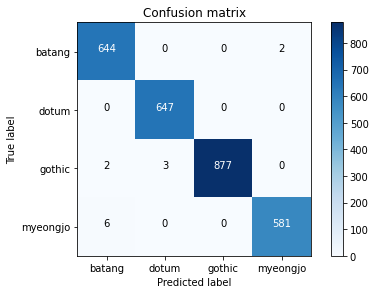

In [ ]:
# Predict the values from the validation dataset
y_pred=loaded_model.predict(X_test)
# Convert predictions classes to one hot vectors
y_pred = np.argmax(y_pred, axis = 1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test,y_pred)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = ['batang','dotum','gothic','myeongjo'])

In [ ]:
2749/2762

0.9952932657494569